In [8]:
#Downloading dataset from google drive public link
#!gdown 1UiquUv_m-k_-UOmd1hFA66K5URrfzszX

Downloading...
From: https://drive.google.com/uc?id=1UiquUv_m-k_-UOmd1hFA66K5URrfzszX
To: /content/occupancy.csv
100% 1.38M/1.38M [00:00<00:00, 51.8MB/s]


In [9]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#Reading CSV
df1=pd.read_csv("occupancy.csv")

In [11]:
df1.shape

(20560, 7)

In [12]:
df1.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [13]:
df1.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [14]:
df1.duplicated().sum()

0

In [15]:
df=df1.copy()

In [16]:
#drop column that is  not useful in model training
df=df.drop("date",axis=1)

In [17]:
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


<Axes: >

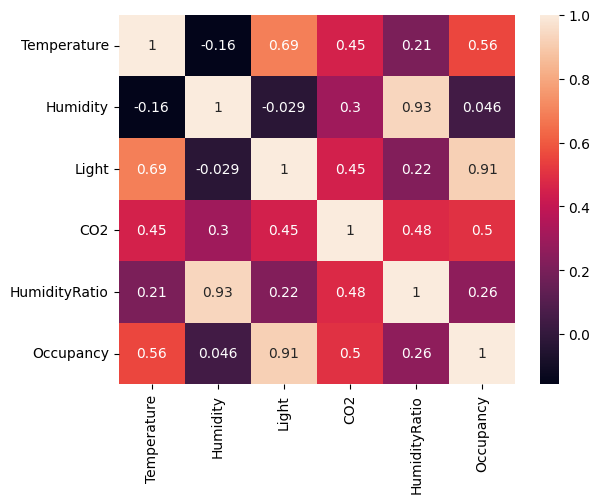

In [18]:
sns.heatmap(df.corr(),annot=True)

In [19]:
df2=df[["Humidity","HumidityRatio"]]
df2.head()

,Humidity,HumidityRatio
0,26.272,0.004764
1,26.290,0.004773
2,26.230,0.004765
3,26.125,0.004744
4,26.200,0.004767


<Axes: >

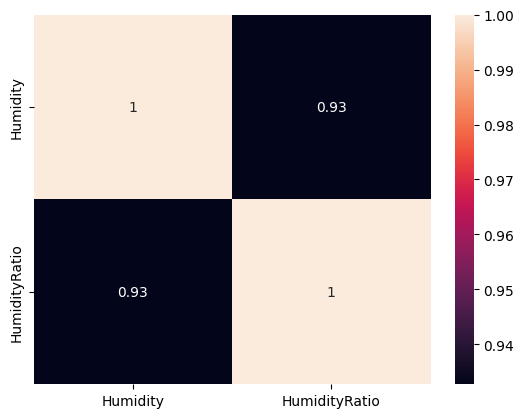

In [20]:
sns.heatmap(df2.corr(),annot=True)

In [21]:
#since humidity and humidityRatio are highly correlated we can drop one of them
df=df.drop("Humidity",axis=1)

In [22]:
df.head()

,Temperature,Light,CO2,HumidityRatio,Occupancy
0,23.7000,585.200000,749.200000,0.004764,1
1,23.7180,578.400000,760.400000,0.004773,1
2,23.7300,572.666667,769.666667,0.004765,1
3,23.7225,493.750000,774.750000,0.004744,1
4,23.7540,488.600000,779.000000,0.004767,1


In [23]:
X=df.drop("Occupancy",axis=1)
y=df["Occupancy"]

In [24]:
df1.Occupancy.value_counts()
#imbalanced data

0    15810
1     4750
Name: Occupancy, dtype: int64

In [25]:
#oversampling gives accuracy of 99.2%
#handle imbalanced data using oversampling
from imblearn.over_sampling import SMOTE
#smote stands for synthetic minority  oversampling technique
from collections import Counter
oversampler=SMOTE()
X,y=oversampler.fit_resample(X,y)
Counter(y)

Counter({1: 15810, 0: 15810})

In [26]:
# #undersampling
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter
# undersampler=RandomUnderSampler()
# X,y=undersampler.fit_resample(X,y)
# Counter(y)

In [27]:
#splitting dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [28]:
#Scaling data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)

In [30]:
#xgboost classifier
import xgboost as xgb
from sklearn.metrics import classification_report
model=xgb.XGBClassifier(max_depth=3,reg_alpha=0.5,reg_lambda=0.5)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4740
           1       0.99      1.00      0.99      4746

    accuracy                           0.99      9486
   macro avg       0.99      0.99      0.99      9486
weighted avg       0.99      0.99      0.99      9486



In [31]:
import pickle
with open('model_xg.pkl', 'wb') as file:
    pickle.dump(model, file)

In [35]:
#Artificial Neural Network
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(4, input_shape=(4,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train,y_train,epochs=1)
y_pred=model.predict(x_test)> 0.5

297/297 [==============================] - 0s 1ms/step


<Axes: >

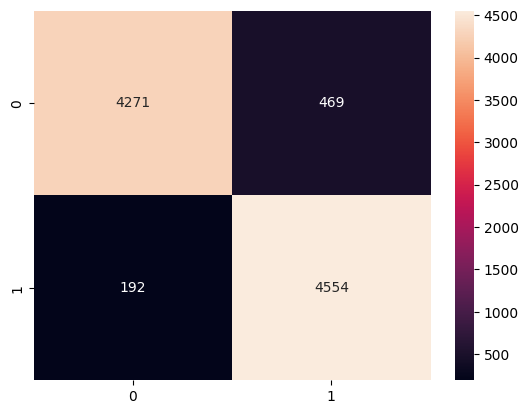

In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="g")

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4740
           1       0.91      0.96      0.93      4746

    accuracy                           0.93      9486
   macro avg       0.93      0.93      0.93      9486
weighted avg       0.93      0.93      0.93      9486



In [39]:
model.save("model_det.h5")